<a href="https://colab.research.google.com/github/algroznykh/notebooks/blob/master/texture_nca_pytorch_io.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Texture Generation with Neural Cellular Automata](https://distill.pub/selforg/2021/textures) (PyTorch version)

This notebook contains a minimalistic PyTorch implementation of the Texture Nerual CA model. For pretrained models and other experiments please refer to the [TF2 version](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/texture_nca_tf2.ipynb).

*Copyright 2021 Google LLC*

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

[https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#@title Imports and Notebook Utilities
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-243bfa6d-f038-381f-28aa-4b913704e4e7)


In [ ]:
import torch
import torchvision.models as models
import torch.nn.functional as F

torch.set_default_tensor_type('torch.cuda.FloatTensor')


# !pip install -q --progress-bar off pykeops[colab] geomloss
# from geomloss import SamplesLoss

In [ ]:
#@title VGG16-based Style Model
vgg16 = models.vgg16(pretrained=True).features

def calc_styles(imgs):
  style_layers = [1, 6, 11, 18, 25]  

#   style_layers = [11, 15, 19, 21, 25]  
  mean = torch.tensor([0.485, 0.456, 0.406])[:,None,None]
  std = torch.tensor([0.229, 0.224, 0.225])[:,None,None]
  x = (imgs-mean) / std
  grams = []
  for i, layer in enumerate(vgg16[:max(style_layers)+1]):
    x = layer(x)
    if i in style_layers:
      h, w = x.shape[-2:]
      y = x.clone()  # workaround for pytorch in-place modification bug(?)
      gram = torch.einsum('bchw, bdhw -> bcd', y, y) / (h*w)
      grams.append(gram)
  return grams

def style_loss(grams_x, grams_y):
  loss = 0.0
  for x, y in zip(grams_x, grams_y):
    loss = loss + (x-y).square().mean()
  return loss

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [188]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

def perchannel_conv(x, filters):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [1, 1, 1, 1], 'circular')
  y = torch.nn.functional.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap])
  return perchannel_conv(x, filters)

class CA(torch.nn.Module):
  def __init__(self, chn=12, hidden_n=96):
    super().__init__()
    self.chn = chn
    # p = torch.nn.Conv2d(chn, chn*4, 3, groups=int(chn/3))
    # torch.nn.init.uniform(p.weight, -.1, .1)
    # self.p = p
    # self.p.requires_grad = False
    self.w1 = torch.nn.Conv2d((chn-6)*4 + 6, hidden_n, 1)
    # self.ww = torch.nn.Conv2d(hidden_n, hidden_n, 1)
    self.w2 = torch.nn.Conv2d(hidden_n, chn, 1, bias=False)#, groups=self.chn)
    self.w2.weight.data.zero_()

    self.act = torch.nn.ReLU()

  def forward(self, x, update_rate=0.8):
    
    # y = perception(x)
    # self.y = y
    y = torch.cat([x[:,:3,...], perception(x[:,3:-3,...]), x[:, -3:, ...]], 1)
    # y = torch.nn.functional.pad(x, [1, 1, 1, 1], 'circular')
    # y = self.p(y)

    # y = self.w2(torch.relu(self.w1(y)))
    y = self.w1(y)
    # y = self.ww(y)
    y = self.w2(self.act(y))

    b, c, h, w = y.shape

    # # different channel update rate experiment
    r1 = torch.rand(b, c//4, h, w)+update_rate 
    r2 = torch.rand(b, c//4, h, w)+update_rate 
    r3 = torch.rand(b, c//4, h, w)+update_rate 
    r4 = torch.rand(b, c//4, h, w)+update_rate
    update_mask = torch.cat([r1,r2,r3,r4], 1)
    update = torch.cat([y[:,ch:ch+3,...] * r.floor() for ch, r in zip(range(self.chn)[::3], [r1, r2, r3, r4])], 1)
    # update_mask = (torch.rand(b, c, h, w)+update_rate).floor()
    # alive = torch.nn.functional.max_pool2d(x[:,:,:,:], 3, stride=1, padding=1) < .1 
    # update = y
    update += x
    # return update
    return torch.cat([update[:, :-3, ...], x[:, -3:, ...]], 1)
    # return x + update 

  def seed(self, n, sz=128):
    zz = makez(n)
    # return torch.cat([zz, zz, torch.zeros((n, self.chn //2, sz, sz))], 1)
    return torch.cat([torch.rand(n, self.chn -3 , sz, sz) / 10., zz], 1)

def to_rgb(x):
  return x[...,:3,:,:] # +0.5

param_n = sum(p.numel() for p in CA().parameters())
print('CA param count:', param_n)

CA param count: 4128


(128, 128, 3)


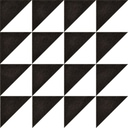

In [ ]:
#@title Target image {vertical-output: true}
style_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/Tempera%2C_charcoal_and_gouache_mountain_painting_by_Nicholas_Roerich.jpg/301px-Tempera%2C_charcoal_and_gouache_mountain_painting_by_Nicholas_Roerich.jpg'
style_url = 'https://duckduckgo.com/i/138d5852.gif'
style_url = 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse3.mm.bing.net%2Fth%3Fid%3DOIP.b7nEZH0P79RL9SoTdugyAgHaFo%26pid%3DApi&f=1'
style_url = 'http://3.bp.blogspot.com/-bVSvErk0AcQ/UwbIrKsF0UI/AAAAAAAAGOc/izt5B8B0zt4/s1600/penrose_triangle.jpg'
style_url2 = 'https://www.cut-the-knot.org/Curriculum/Geometry/Tremas.jpg'
style_url = 'https://cdn.webshopapp.com/shops/285805/files/316417389/luxury-tiles-aspen-black-and-white-triangle-porcel.jpg'
style_img = imread(style_url, max_size=128)
style_img2 = imread(style_url2, max_size=128)

print(style_img.shape)
with torch.no_grad():
  target_style = calc_styles(to_nchw(style_img))
  target_style90 = calc_styles(to_nchw(np.copy(np.flip(style_img2))))
imshow(style_img)

# learning to translate

In [ ]:
from scipy.ndimage.filters import gaussian_filter


spread = 5.
sz = 128
spot_prob = .0001

def makez2(bs, sz=128):

    z = torch.floor(torch.rand([bs, sz, sz, 1], )+spot_prob) * 100.
    z = gaussian_filter(z.cpu(), [0.0, spread, spread, 0.0], mode='wrap')
    # z = torch.cat([z for _ in range(3)], -1)
    # z = z**2
    z = np.repeat(z, 3, -1)
    z = np.moveaxis(z, -1, 1)
    return torch.tensor(z)

z2 = makez2(4)
def makez(*args,**kw):
    return makez2(*args, **kw)

In [193]:
#@title setup training
ca = CA() 
opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [2000], 0.3)
loss_log = []
with torch.no_grad():
#   pool = ca.seed(256)
#   zzz = makez(256)
#   pool = torch.cat([zzz for _ in range(4)], 1)
  pool = ca.seed(256)
#   pool = torch.cat([makez(256), torch.zeros((256, 12-3, 128, 128))], 1)

In [ ]:
l2_target = torch.stack([torch.tensor(style_img).permute((-1, 0, 1)) for _ in range(4)])

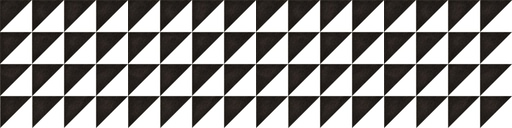

In [ ]:
imshow(np.hstack(l2_target.permute([0,2,3,1]).cpu().numpy()))

In [ ]:
from torchvision.transforms.functional import resize 
def zx2(t):
  return resize(t[..., 32:96, 32:96], [128, 128])

In [ ]:
def prep(t):
  return t.permute([0, 2, 3, 1]).cpu()

In [ ]:
def shift(t, px):
  return torch.cat([t[:,:,px:,:], t[:,:,:px,:]], 2)


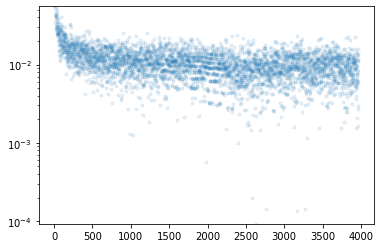

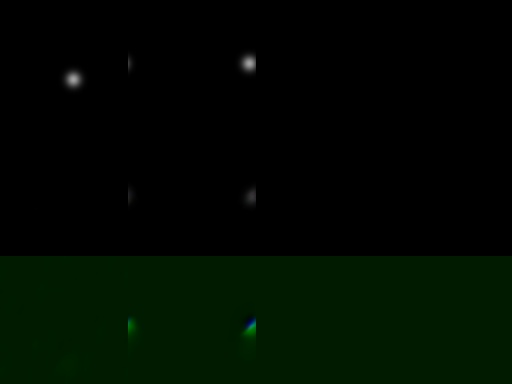

step_n: 3991  loss: 0.00593955023214221  lr: 0.0003

In [194]:
#@title training loop {vertical-output: true}

for i in range(4000):
  with torch.no_grad():
    batch_idx = np.random.choice(len(pool), 4, replace=False)
    x = pool[batch_idx]
    if i%32 == 0:
      x[:1] = ca.seed(1)
        # x[:,:3,:,:] = makez(4)
        # x = ca.seed(4)
#   step_n = np.random.randint(32, 96)
  step_n = np.random.randint(32, 96)


  # inx = zx2(to_rgb(x[:,-3:,...]))
  inx = shift(to_rgb(x[:,-3:,...]), 32)



  # The following line is equivalent to this code:
  #   for k in range(step_n):
  #     x = ca(x) 
  # It uses gradient checkpointing to save memory, which enables larger
  # batches and longer CA step sequences. Surprisingly, this version
  # is also ~2x faster than a simple loop, even though it performs
  # the forward pass twice!
  x = torch.utils.checkpoint.checkpoint_sequential([ca]*step_n, 16, x)
  imgs = to_rgb(x)
  # styles = calc_styles(imgs)
  # overflow_loss = (x-x.clamp(-1.0, 1.0)).abs().sum()

#   outx = torch.stack([im.flip(1) for im in inx])
  # outx = torch.stack([im.flip(1) for im in to_rgb(x[:,:3, ...])])
  outx = to_rgb(x[:, :3, ...])

#   outx = inx

#   io_loss = (outx - to_rgb(x[:,-3:,:,:])).square().sum()
  # io_loss = F.mse_loss(inx, outx) * 100
  io_loss = (outx - inx).abs().mean()
  # io_loss = F.mse_loss(torch.stack([im.flip(1) for im in inx]), outx)
  # io_loss = ot_loss(torch.stack([im.flip(1) for im in inx]), outx)
#   io_loss = style_loss(calc_styles(outx), [st.flip(1) for st in target_style]) + overflow_loss
  # io_loss = style_loss(calc_styles(outx), target_style90) + overflow_loss


  # loss = style_loss(styles, target_style) + overflow_loss
#   loss = (to_rgb(x) - l2_target).square().sum()
#   loss = F.mse_loss(to_rgb(x), l2_target) * 100
  loss = io_loss

  with torch.no_grad():
    loss.backward()
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients 
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool
    
    loss_log.append(loss.item())
    if i%64==0:
      clear_output(True)
      pl.plot(loss_log, '.', alpha=0.1)
      pl.yscale('log')
      pl.ylim(np.min(loss_log), loss_log[0])
      pl.show()
    #   imgs = to_rgb(x).permute([0, 2, 3, 1]).cpu()
      imgs = inx.permute([0, 2, 3, 1]).cpu()
      imgs2 = to_rgb(x).permute([0,2,3,1]).cpu()


      imgs3 = to_rgb(x[:,3:6,:,:]).permute([0,2,3,1]).cpu()
      imshow(np.vstack([np.hstack(imgs), np.hstack(imgs2), np.hstack(imgs3)]))
    if i%10 == 0:
      print('\rstep_n:', len(loss_log),
        ' loss:', loss.item(), 
        ' lr:', lr_sched.get_lr()[0], end='')


In [ ]:
torch.save(ca, 'ab_{}.pt'.format(len(loss_log)))

In [191]:
#@title NCA video {vertical-output: true}
with VideoWriter() as vid, torch.no_grad():
  x = ca.seed(1, sz=128)
#   x = torch.cat([makez2(1, sz=128), torch.zeros((1, 12-3, 128, 128))], 1)
  for k in tnrange(300, leave=False):
    step_n = min(2**(k//30), 16)
    for i in range(step_n):
      x[:] = ca(x)
    # img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    img = np.vstack([np.hstack([to_rgb(x[:,row:row+3,...][0]).permute(1, 2, 0).cpu() for row in range(col, col+6)[::3]]) for col in range(ca.chn)[::6]])

    vid.add(zoom(img, 2))

  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
 #@title NCA video {vertical-output: true}


# return torch.cat([zz, zz, torch.zeros((n, self.chn //2, sz, sz))], 1)
with VideoWriter() as vid, torch.no_grad():
  # x = ca.seed(1, sz=256)

  x = torch.cat([torch.rand(1, 12 -3 , 256, 256) / 10., makez(1, 256)], 1)
#   x = torch.cat([makez2(1, sz=128), torch.zeros((1, 12-3, 128, 128))], 1)
  for k in tnrange(450, leave=False):
    step_n = min(2**(k//30), 16)
    for i in range(step_n):
      x[:] = ca(x, update_rate=.8)
    # img = to_rgb(x[0]).permute(1, 2, 0).cpu()
    img = np.vstack([np.hstack([to_rgb(x[:,row:row+3,...][0]).permute(1, 2, 0).cpu() for row in range(col, col+6)[::3]]) for col in range(ca.chn)[::6]])

    vid.add(zoom(img, 2))

  0%|          | 0/450 [00:00<?, ?it/s]